Exercise 0: Clone the repository

In [1]:
try:
    ! git clone https://github.com/cs612-smu/cs612-smu-2025 CS612_SMU
    HOME_DIR = "./CS612_SMU/week1/"
except:
    print('Already clone!!!')

fatal: destination path 'CS612_SMU' already exists and is not an empty directory.


Exercise 1: In this exercise, you will use colab to train a simple neural network for classifying the MNIST dataset.

In [14]:
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from datetime import datetime

import os
import contextlib


class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = x # cross entropy in pytorch already includes softmax
        return output


def save_model(model, name):
    torch.save(model.state_dict(), name)


def train(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))


def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    loss, correct = 0.0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()

    loss /= num_batches
    correct /= size
    print('Test Error: \n Accuracy: {:.2f}%, Avg loss: {:.4f}\n'.format(100 * correct, loss))


device = 'cpu'
train_kwargs = {'batch_size': 100}
test_kwargs = {'batch_size': 1000}
transform = transforms.ToTensor()

# Suppress download messages
with contextlib.redirect_stdout(open(os.devnull, 'w')), \
     contextlib.redirect_stderr(open(os.devnull, 'w')):
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

model = MNISTNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1)
num_of_epochs = 20

start = datetime.now()

for epoch in range(num_of_epochs):
    print('\n------------- Epoch {} -------------\n'.format(epoch))
    train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
    test(model, test_loader, nn.CrossEntropyLoss(), device)
    
end = datetime.now()
diff = end - start
print('\nDuration (sec): {}'.format(diff.total_seconds()))

save_model(model, './mnist.pt')



------------- Epoch 0 -------------

loss: 2.3157 [0/60000]
loss: 2.0163 [10000/60000]
loss: 1.4400 [20000/60000]
loss: 1.3451 [30000/60000]
loss: 0.9029 [40000/60000]
loss: 0.7135 [50000/60000]
Test Error: 
 Accuracy: 79.77%, Avg loss: 0.6595


------------- Epoch 1 -------------

loss: 0.6963 [0/60000]
loss: 0.6189 [10000/60000]
loss: 0.7066 [20000/60000]
loss: 0.6051 [30000/60000]
loss: 0.4201 [40000/60000]
loss: 0.5037 [50000/60000]
Test Error: 
 Accuracy: 84.66%, Avg loss: 0.5244


------------- Epoch 2 -------------

loss: 0.4559 [0/60000]
loss: 0.5177 [10000/60000]
loss: 0.6190 [20000/60000]
loss: 0.5203 [30000/60000]
loss: 0.3517 [40000/60000]
loss: 0.5103 [50000/60000]
Test Error: 
 Accuracy: 87.48%, Avg loss: 0.4524


------------- Epoch 3 -------------

loss: 0.3437 [0/60000]
loss: 0.4377 [10000/60000]
loss: 0.4922 [20000/60000]
loss: 0.4499 [30000/60000]
loss: 0.3237 [40000/60000]
loss: 0.4603 [50000/60000]
Test Error: 
 Accuracy: 88.31%, Avg loss: 0.4247


------------- E

Exercise 2: Generate adversarial samples and save them

In [5]:
import torch
import torch.nn.functional as F

def fgsm_attack(model, x, y, eps):
    x_adv = x.clone().detach().requires_grad_(True)
    pred = model(x_adv)
    loss = F.cross_entropy(pred, y)
    loss.backward()
    grad = x_adv.grad.data
    x_adv = torch.clamp(x_adv + eps * grad.sign(), 0, 1).detach()
    return x_adv

# Example: Generate and save 100 adversarial examples
adversarial_examples = []
adversarial_labels = []

model.eval()
eps = 0.2
count = 0
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
for x, y in test_loader:
    x_adv = fgsm_attack(model, x, y, eps)
    adversarial_examples.append(x_adv.squeeze(0).cpu().numpy())
    adversarial_labels.append(y.item())
    count += 1
    if count == 5000:
        break

import numpy as np
np.save('./adv_examples.npy', np.array(adversarial_examples))
np.save('./adv_labels.npy', np.array(adversarial_labels))

Visualize first 10 adversarial examples

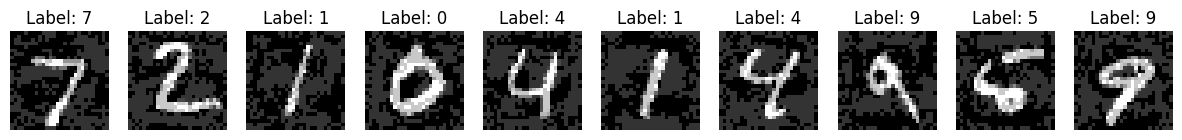

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Load the saved adversarial examples and labels
adv_examples = np.load('./adv_examples.npy')
adv_labels = np.load('./adv_labels.npy')

# Visualize the first 10 adversarial examples
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(adv_examples[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {adv_labels[i]}")
    plt.axis('off')

Sanity check

Index 0: True label=7, Model(orig)=7, Model(adv)=5


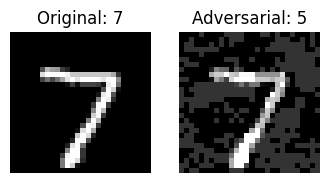

Index 1: True label=2, Model(orig)=2, Model(adv)=3


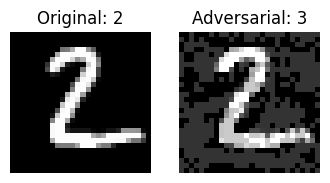

Index 2: True label=1, Model(orig)=1, Model(adv)=5


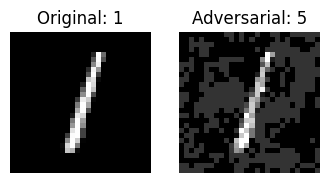

Index 3: True label=0, Model(orig)=0, Model(adv)=7


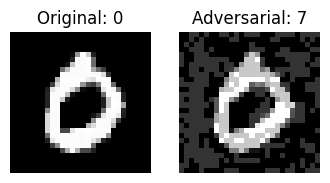

Index 4: True label=4, Model(orig)=4, Model(adv)=7


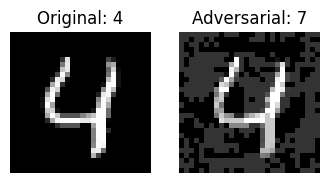

Index 5: True label=1, Model(orig)=1, Model(adv)=7


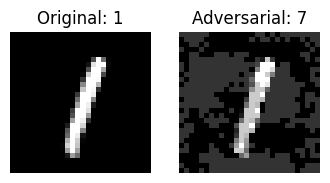

Index 6: True label=4, Model(orig)=4, Model(adv)=8


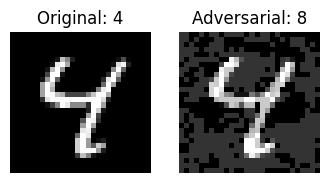

Index 7: True label=9, Model(orig)=9, Model(adv)=1


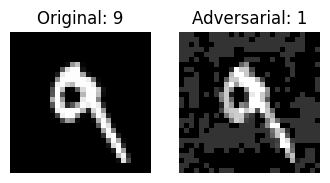

Index 8: True label=5, Model(orig)=5, Model(adv)=6


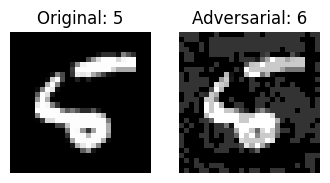

Index 9: True label=9, Model(orig)=9, Model(adv)=4


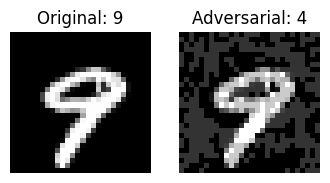

In [9]:
for i in range(10):
    orig = test_dataset[i][0].unsqueeze(0)  # original image tensor
    orig_label = test_dataset[i][1]
    adv = torch.tensor(adv_examples[i]).unsqueeze(0)
    pred_orig = model(orig).argmax(1).item()
    pred_adv = model(adv).argmax(1).item()
    print(f"Index {i}: True label={orig_label}, Model(orig)={pred_orig}, Model(adv)={pred_adv}")

    # Visualize original and adversarial images side by side
    plt.figure(figsize=(4,2))
    plt.subplot(1,2,1)
    plt.imshow(orig.squeeze().numpy(), cmap='gray')
    plt.title(f"Original: {pred_orig}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(adv.squeeze().numpy(), cmap='gray')
    plt.title(f"Adversarial: {pred_adv}")
    plt.axis('off')
    plt.show()

Train new robust model

In [19]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load original training data
train_images = train_dataset.data.numpy() / 255.0  # shape: (60000, 28, 28)
train_labels = train_dataset.targets.numpy()       # shape: (60000,)

# Load adversarial data
adv_images = np.load('./adv_examples.npy')         # shape: (5000, 28, 28)
adv_labels = np.load('./adv_labels.npy')           # shape: (5000,)

# Remove channel dimension from adv_images if present
if adv_images.ndim == 4 and adv_images.shape[1] == 1:
    adv_images = adv_images.squeeze(1)  # Now shape is (5000, 28, 28)

# Stack and create tensors
all_images = np.concatenate([train_images, adv_images], axis=0)
all_labels = np.concatenate([train_labels, adv_labels], axis=0)

all_images = torch.tensor(all_images, dtype=torch.float32).unsqueeze(1)  # (N, 1, 28, 28)
all_labels = torch.tensor(all_labels, dtype=torch.long)

robust_dataset = TensorDataset(all_images, all_labels)
robust_loader = DataLoader(robust_dataset, batch_size=100, shuffle=True)

train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  # (N, 1, 28, 28)
train_labels = torch.tensor(train_labels, dtype=torch.long)
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)


# robust_model = MNISTNet()
# optimizer = torch.optim.SGD(robust_model.parameters(), lr=0.1)
# loss_fn = torch.nn.CrossEntropyLoss()


# num_epochs = 20
# device = 'cpu'
# robust_model.to(device)

# for epoch in range(num_epochs):
#     robust_model.train()
#     for x, y in robust_loader:
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad()
#         pred = robust_model(x)
#         loss = loss_fn(pred, y)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1} finished.")

# # Save the robust model
# torch.save(robust_model.state_dict(), './mnist_robust_ex5.pt')

device = 'cpu'
train_kwargs = {'batch_size': 100}
test_kwargs = {'batch_size': 1000}
transform = transforms.ToTensor()

# # Suppress download messages
# with contextlib.redirect_stdout(open(os.devnull, 'w')), \
#      contextlib.redirect_stderr(open(os.devnull, 'w')):
#     # train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
#     test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# # train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
# test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

model = MNISTNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1)
num_of_epochs = 20

start = datetime.now()

for epoch in range(num_of_epochs):
    print('\n------------- Epoch {} -------------\n'.format(epoch))
    train(model, train_loader, nn.CrossEntropyLoss(), optimizer, device)
    test(model, test_loader, nn.CrossEntropyLoss(), device)
    
end = datetime.now()
diff = end - start
print('\nDuration (sec): {}'.format(diff.total_seconds()))

save_model(model, './mnist_ex5.pt')


------------- Epoch 0 -------------

loss: 2.3283 [0/60000]
loss: 2.1652 [10000/60000]
loss: 2.3322 [20000/60000]
loss: 1.0244 [30000/60000]
loss: 0.7975 [40000/60000]
loss: 0.5313 [50000/60000]
Test Error: 
 Accuracy: 83.71%, Avg loss: 0.5193


------------- Epoch 1 -------------

loss: 0.4521 [0/60000]
loss: 0.4338 [10000/60000]
loss: 0.6724 [20000/60000]
loss: 0.4658 [30000/60000]
loss: 0.2776 [40000/60000]
loss: 0.3246 [50000/60000]
Test Error: 
 Accuracy: 90.68%, Avg loss: 0.3075


------------- Epoch 2 -------------

loss: 0.3075 [0/60000]
loss: 0.1537 [10000/60000]
loss: 0.2077 [20000/60000]
loss: 0.2597 [30000/60000]
loss: 0.3984 [40000/60000]
loss: 0.3454 [50000/60000]
Test Error: 
 Accuracy: 91.65%, Avg loss: 0.2757


------------- Epoch 3 -------------

loss: 0.2304 [0/60000]
loss: 0.2403 [10000/60000]
loss: 0.2934 [20000/60000]
loss: 0.3352 [30000/60000]
loss: 0.1702 [40000/60000]
loss: 0.3871 [50000/60000]
Test Error: 
 Accuracy: 92.71%, Avg loss: 0.2496


------------- E

Compare models

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def fgsm_attack(model, x, y, eps):
    x_adv = x.clone().detach().requires_grad_(True)
    pred = model(x_adv)
    loss = F.cross_entropy(pred, y)
    loss.backward()
    grad = x_adv.grad.data
    x_adv = torch.clamp(x_adv + eps * grad.sign(), 0, 1).detach()
    return x_adv

# Use the original model for attack generation
attack_model = original_model
attack_model.eval()
eps = 0.2

new_adv_examples = []
new_adv_labels = []

for i in range(1000):
    x, y = test_dataset[i]
    x = x.unsqueeze(0)
    y = torch.tensor([y])
    x_adv = fgsm_attack(attack_model, x, y, eps)
    new_adv_examples.append(x_adv.squeeze(0).cpu().numpy())
    new_adv_labels.append(y.item())

new_adv_examples = np.array(new_adv_examples)
new_adv_labels = np.array(new_adv_labels)

# Prepare tensors
new_adv_examples_tensor = torch.tensor(new_adv_examples, dtype=torch.float32).unsqueeze(1)
new_adv_labels_tensor = torch.tensor(new_adv_labels, dtype=torch.long)

def attack_success_rate(model, adv_x, true_y):
    success = 0
    total = len(true_y)
    with torch.no_grad():
        for i in range(total):
            x = adv_x[i].unsqueeze(0)
            y = true_y[i].item()
            pred = model(x).argmax(1).item()
            if pred != y:
                success += 1
    return success / total

orig_success = attack_success_rate(original_model, new_adv_examples_tensor, new_adv_labels_tensor)
robust_success = attack_success_rate(robust_model, new_adv_examples_tensor, new_adv_labels_tensor)

print(f"Original model attack success rate: {orig_success*100:.2f}%")
print(f"Robust model attack success rate:   {robust_success*100:.2f}%")

Original model attack success rate: 97.10%
Robust model attack success rate:   69.60%
